# Amazon Product Recommendation System

**Summary**  
This notebook builds a model-based collaborative filtering system from Amazon Beauty product ratings.  

**Dataset**  
Kaggle: https://www.kaggle.com/datasets/skillsmuggler/amazon-ratings

## Setup & Imports

Import libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import TruncatedSVD

plt.style.use("ggplot")

## Load Data

Load the Amazon Beauty ratings dataset from a CSV file into a pandas DataFrame for processing.

In [2]:
ratings = pd.read_csv('ratings_Beauty.csv')
ratings = ratings.dropna()
ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


## Quick Data Audit

Inspect the dataset.

In [3]:
ratings.shape

(2023070, 4)

Top 10 products by popularity

In [4]:
#sort products by popularity (rating count)

popular_products = pd.DataFrame(ratings.groupby('ProductId')['Rating'].count())
most_popular = popular_products.sort_values('Rating', ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


Top 30 products by popularity

<Axes: xlabel='ProductId'>

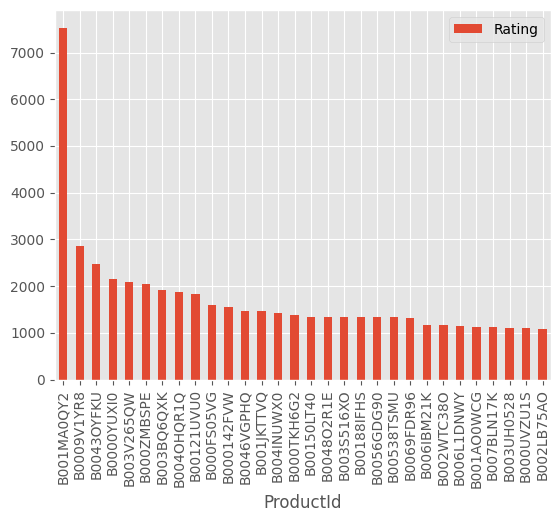

In [5]:
most_popular.head(30).plot(kind = "bar")

## Prepare Ratings Utility Matrix

Gather sample of amazon dataset

In [6]:
ratings_sample = ratings.head(20000)

In [7]:
ratings_utility_matrix = ratings_sample.pivot_table(values='Rating', index='UserId', columns='ProductId', fill_value=0)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B00005BJ8X,B00005BJ91,B00005BL1R,B00005BLRH,B00005BWXD,B00005CDRP,B00005CDRY,B00005CDS5,B00005CDS7,B00005CDS9
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A00473363TJ8YSZ3YAGG9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A01437583CZ7V02UKZQ5S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A020135981U0UNEAE4JV,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A024581134CV80ZBLIZTZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
ratings_utility_matrix.shape

(19101, 1398)

In [9]:
# Transpose the matrix

X = ratings_utility_matrix.T
X.head()

UserId,A00205921JHJK5X9LNP42,A00473363TJ8YSZ3YAGG9,A01437583CZ7V02UKZQ5S,A020135981U0UNEAE4JV,A024581134CV80ZBLIZTZ,A03056581JJIOL5FSKJY7,A03099101ZRK4K607JVHH,A03454732N8VEYJAMGTTH,A0505229A7NSH3FRXRR4,A05492663T95KW63BR75K,...,AZYR51QTD6FAY,AZZ5ENX41WOYZ,AZZ8A0TEQOD7J,AZZDA9BRMPP1B,AZZHB6U54UDYW,AZZHJZP4GQPPZ,AZZNK89PXD006,AZZOFVMQC0BJG,AZZQXL8VDCFTV,AZZTJQ7CQZUD8
ProductId,,,,,,,,,,,,,,,,,,,,,
0205616461,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0558925278,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0733001998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0737104473,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0762451459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
X.shape

(1398, 19101)

Reduce ratings matrix from a high-dimensional space into 10 features using Singular Value Decomposition. The output "decomposed_matrix" is the lower-dimensional representation, and .shape confirms the new size.

In [11]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1398, 10)

Compute correlation between rows

In [12]:
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1398, 1398)

## Product Recommendation Modeling

Select a Product ID at random to simulate a product purchased by a hypotheical customer, and determine product recommendations

In [13]:
# Select a product at random to isolate from correlation matrix

random_index = np.random.randint(0, len(X))
print("Random index:", random_index)
print("Product ID: ", X.index[random_index])

i = X.index[random_index]

product_names = list(X.index)
product_ID = product_names.index(i)

Random index: 425
Product ID:  9790783728


Compute correlation between all items and the item purchased by this customer based on items rated by other customers who bought the same product as generated above.

In [14]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1398,)

### Recommendations

Provide top 10 product recommendations ranked by prediction scores.

In [15]:
# Gather recomended Product ID's and remove the product already purchased by the customer

Recommend = list(X.index[correlation_product_ID > 0.90])

Recommend.remove(i)

Recommend[0:9]

['0733001998',
 '130414089X',
 '6117036094',
 '6162071103',
 '8096398741',
 '9573086514',
 '9758086243',
 '978807250X',
 '9788074421']